In [1]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import keras

%matplotlib inline

Using TensorFlow backend.


In [3]:
data = np.load("fmri_preprocessed_2017_09_18.npy")
data = np.transpose(data)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
data = np.transpose(data)
data = np.expand_dims(data, axis=2)

random = np.random.permutation(np.shape(data)[0])
ratio = .70
number = int(ratio * np.shape(random)[0])
print(number)
training = data[0:number,:,:]
test = data[number:,:,:]


print('Training data shape:', np.shape(training))
print('Testing data shape:', np.shape(test))

np.save('../../../Results/Pig 2/Base/embeddings-squished.npy', data)

11539
Training data shape: (11539, 300, 1)
Testing data shape: (4946, 300, 1)


/home/chris/projects/rfmri/pig/envi/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
def m2():
    from keras.models import Sequential
    from keras.layers import Conv1D, MaxPooling1D, UpSampling1D
    from keras import regularizers
    
    filters = [10, 50, 150, 300]
    kernel_size = [10, 10, 10, 10]
    pool_size = [2, 3, 5, 10]
    upsample_size = [2, 3, 5, 10]
    weight_decay = 0.00001
    
    model = Sequential()
        ### Encoding portion
    model.add(Conv1D(filters[0],
                         kernel_size[0],
                         input_shape=(300,1),
                         activation='relu',
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay)))
    #model.add(BatchNormalization(axis=-1, momentum=0.99))
    model.add(MaxPooling1D(pool_size[0], padding='same'))

    model.add(Conv1D(filters[1],
                         kernel_size[1],
                         activation='relu',
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay)))
    #model.add(BatchNormalization(axis=-1, momentum=0.99))
    model.add(MaxPooling1D(pool_size[1], padding='same'))

    model.add(Conv1D(filters[2],
                         kernel_size[2],
                         activation='relu',
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay)))
    #model.add(BatchNormalization(axis=-1, momentum=0.99))
    model.add(MaxPooling1D(pool_size[2], padding='same'))
    
    model.add(Conv1D(filters[3],
                         kernel_size[3],
                         activation='relu',
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay)))
    #model.add(BatchNormalization(axis=-1, momentum=0.99))
    model.add(MaxPooling1D(pool_size[3], padding='same'))


    ### Decoding portion
    model.add(Conv1D(filters[3],
                         kernel_size[3],
                         activation='relu',
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay)))
    #model.add(BatchNormalization(axis=-1, momentum=0.99))
    model.add(UpSampling1D(upsample_size[3]))
    
    model.add(Conv1D(filters[2],
                         kernel_size[2],
                         activation='relu',
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay)))
    #model.add(BatchNormalization(axis=-1, momentum=0.99))
    model.add(UpSampling1D(upsample_size[2]))
    
    model.add(Conv1D(filters[1],
                         kernel_size[1],
                         activation='relu',
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay)))
    #model.add(BatchNormalization(axis=-1, momentum=0.99))
    model.add(UpSampling1D(upsample_size[1]))


    model.add(Conv1D(filters[0],
                         kernel_size[0],
                         activation='relu',
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay)))
    #model.add(BatchNormalization(axis=-1, momentum=0.99))
    model.add(UpSampling1D(upsample_size[0]))


        # Decoded output
    model.add(Conv1D(1, 1, activation='linear', padding='same'))

    #sgd = optimizers.SGD(lr=0.001, clipvalue=0.5, momentum=.9, decay=0.0001)
    model.compile(optimizer='Adadelta', loss='mse')
   
    
    return model

auto_model = m2()
auto_model.fit(training, training, batch_size=128, epochs=50, verbose=1, shuffle=True, validation_data=(test,test))


Train on 11539 samples, validate on 4946 samples
Epoch 1/50
11539/11539 [==============================] - 54s - loss: 0.9818 - val_loss: 0.9329
Epoch 2/50
11539/11539 [==============================] - 68s - loss: 0.8971 - val_loss: 0.8424
Epoch 3/50
11539/11539 [==============================] - 69s - loss: 0.8729 - val_loss: 0.8638
Epoch 4/50
11539/11539 [==============================] - 70s - loss: 0.8476 - val_loss: 0.8173
Epoch 5/50
11539/11539 [==============================] - 69s - loss: 0.8387 - val_loss: 0.7892
Epoch 6/50
11539/11539 [==============================] - 70s - loss: 0.8274 - val_loss: 0.7859
Epoch 7/50
11539/11539 [==============================] - 70s - loss: 0.8252 - val_loss: 0.7993
Epoch 8/50
11539/11539 [==============================] - 69s - loss: 0.8181 - val_loss: 0.8246
Epoch 9/50
11539/11539 [==============================] - 69s - loss: 0.8177 - val_loss: 0.7802
Epoch 10/50
11539/11539 [==============================] - 69s - loss: 0.8164 - val_los

In [7]:
auto_model.save('../../../Results/Pig 2/12A/model.h5')

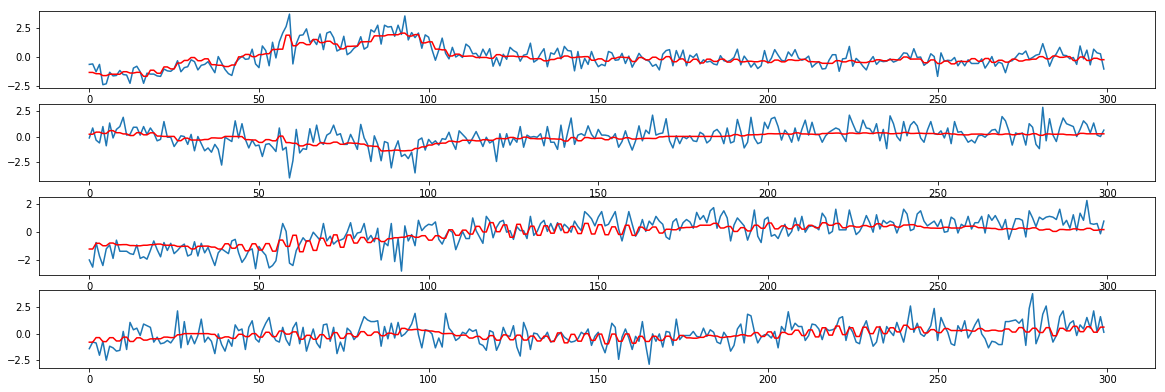

In [8]:
sample_1 = training[np.newaxis, 601]
output_1 = auto_model.predict(sample_1)

sample_2 = training[np.newaxis, 70]
output_2 = auto_model.predict(sample_2)

sample_3 = training[np.newaxis, 896]
output_3 = auto_model.predict(sample_3)

sample_4 = training[np.newaxis, 10387]
output_4 = auto_model.predict(sample_4)


plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(np.squeeze(sample_1))
plt.plot(np.squeeze(output_1), c='r')
plt.subplot(612)
plt.plot(np.squeeze(sample_2))
plt.plot(np.squeeze(output_2), c='r')
plt.subplot(613)
plt.plot(np.squeeze(sample_3))
plt.plot(np.squeeze(output_3), c='r')
plt.subplot(614)
plt.plot(np.squeeze(sample_4))
plt.plot(np.squeeze(output_4), c='r')

plt.savefig('../../../Results/Pig 2/12A/reconstructions.png')

In [12]:
auto_model.layers[7].get_config()

{'name': 'max_pooling1d_4',
 'padding': 'same',
 'pool_size': (10,),
 'strides': (10,),
 'trainable': True}

In [13]:
embedding_model = keras.models.Model(inputs=auto_model.input,
                                 outputs=auto_model.layers[7].output)
embeddings = embedding_model.predict(data)
squished_embeddings = np.reshape(embeddings, (embeddings.shape[0], -1))

In [14]:
print(embeddings.shape)
print(squished_embeddings.shape)
np.save('../../../Results/Pig 2/12A/embeddings-squished.npy', squished_embeddings)

(16485, 1, 300)
(16485, 300)


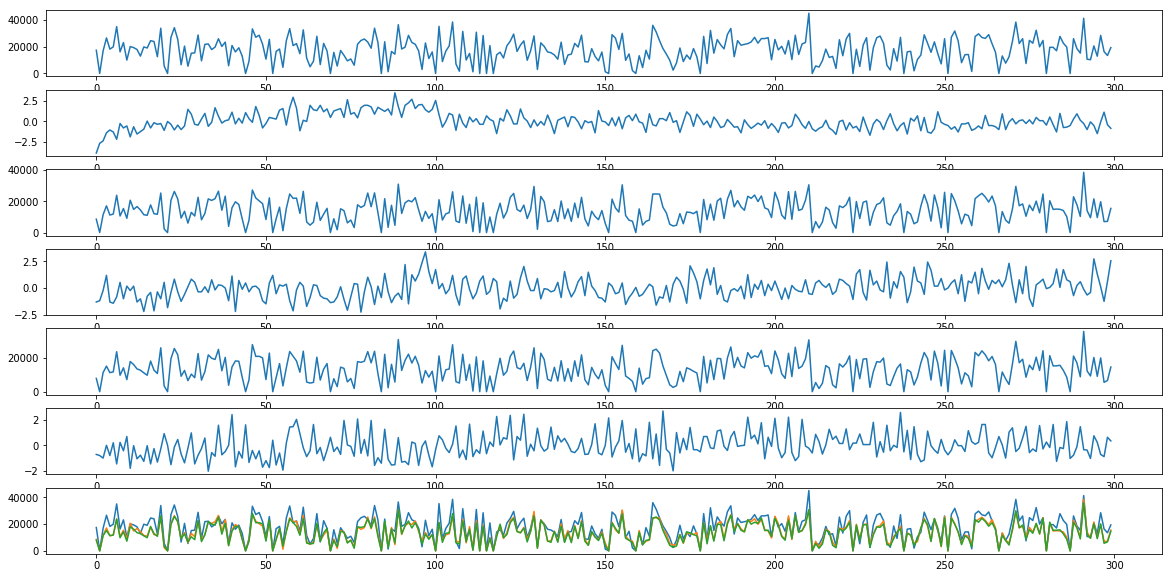

In [15]:
plt.figure(figsize=(20, 10))
plt.subplot(711)
plt.plot(squished_embeddings[100, :])
plt.subplot(712)
plt.plot(data[100,:])
plt.subplot(713)
plt.plot(squished_embeddings[2000, :])
plt.subplot(714)
plt.plot(data[2000,:])
plt.subplot(715)
plt.plot(squished_embeddings[10000, :])
plt.subplot(716)
plt.plot(data[10000,:])
plt.subplot(717)
plt.plot(squished_embeddings[100, :])
plt.plot(squished_embeddings[2000, :])
plt.plot(squished_embeddings[10000, :])

In [6]:
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
squished_embeddings = np.load('../../../Results/Pig 2/12A/embeddings-squished.npy')
scaler = StandardScaler()
data = scaler.fit_transform(squished_embeddings)
np.max(data)
#np.min(data)

128.39363